This is the notebook to use to generate a figure. 
For this, you need to have to have the following: 
- the simulated dataset (w3c)
- the set `.env` at the root with `$WORKSPACE` and `$MAPPERTOOLBOX`

## Step 1) run the Mappers on the configs

The following script will generate the Mapper results, shape graphs, plots, and stats for each configuration set in the configuration.
We will run two sets of MapperToolbox configurations (they will run for a while):

```
./code/utils/run_mapper.sh --poolsize 4 mappers_w3c_clust1.json w3c

```


## Step 2) Analyze the created Mappers graphs (circleness, ...)

Once all the mappers have been computed for the configs, you should analyze the shape graphs based on the circleness criteria and the other statistics:

```
CONF=mappers_w3c_clust1.json
```

Run the below for each of the above configurations:

```
source .env
# module load matlab # Maybe run this if you are running in SLURM
COHORT_PATH="$WORKSPACE/data/w3c/cohort.csv"
DATAFOLDER="$WORKSPACE/results/w3c/${CONF}/"
OUTPUT_DIR="$WORKSPACE/results/w3c/analysis/${CONF}/"
ARGS="datafolder='${DATAFOLDER}'; cohort_path='${COHORT_PATH}'; output_dir='${OUTPUT_DIR}';"
matlab -nodesktop -r "${ARGS} run('$WORKSPACE/code/w3c/circle_test_multitiming.m')"

```

For the rest of the criteria, run the following python script:

```
python3 $WORKSPACE/code/utils/cache.py compute_stats \
    $WORKSPACE/data/w3c/cohort.csv \
    $WORKSPACE/results/w3c/${CONF}/ \
    --output_dir $WORKSPACE/results/w3c/analysis/${CONF}/
```

The above two commands will generate tables of stats within `analysis/${CONF}` directory. 

## Step 3) Generate the figures

In [1]:
import csv
import os
import math
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image as IPyImage, display
from PIL import Image

sns.set(rc={'figure.facecolor':'white'})

# demapper imports for the analysis
from demapper.code.utils.analyze import extract_dataset, get_all_parameters
from demapper.code.utils.config_w3c import DATASETS, FILTERS
from demapper.code.utils.config_mapper import extract_params_f
from demapper.code.utils.utils import filter_dataframe, count_passing, add_col_passing
from demapper.code.utils.plot_grids import plot_grid_params

### Figure (a)

In [2]:
import random
from scipy import stats


sns.set(font_scale=1.5)
sns.set_style(style='white')

PICKED_DATASET = 'w3c-clust1'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract geodesic distances mappers
df_link, max_values1 = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][0], extract_params_f)
df_dbscan, max_values2 = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][1], extract_params_f)
TB_MAX = max(max_values1['TransitionBetweeness'], max_values2['TransitionBetweeness'])
df_link.loc[df_link['TransitionBetweeness'] > max_values1['TransitionBetweeness'] * 0.99, 'TransitionBetweeness'] = TB_MAX
df_dbscan.loc[df_dbscan['TransitionBetweeness'] > max_values2['TransitionBetweeness'] * 0.99, 'TransitionBetweeness'] = TB_MAX

df_link['name'] = df_link.apply(lambda row: 'Linkage_bins={}'.format(row['linkbins']), axis=1)
df_dbscan['name'] = df_dbscan.apply(lambda row: 'DBSCAN_Eps={}'.format(row['clustEps']), axis=1)

target_metrics_limits = {
    'TransitionBetweeness': [0, TB_MAX * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

df = pd.concat([df_link, df_dbscan])

len(stats):  875
len(results):  875
len(stats):  875
len(results):  875


In [3]:

clusts = df['name'].drop_duplicates().to_numpy()
Kvals = df['K'].drop_duplicates().to_numpy()

table = []
for clust in clusts:
    for k in sorted(Kvals):
        fdf = filter_dataframe(df, { 'name': [clust], 'K': [k] })
        cnt = count_passing(fdf, target_metrics_limits)
        table.append({
            'clust': clust,
            'method': clust[:6] if 'DBSCAN' in clust else clust[:7],
            'K': k,
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
        })


counts_df = pd.DataFrame(data=table)

print('max in counts_df:', counts_df['count'].max())


max in counts_df: 22


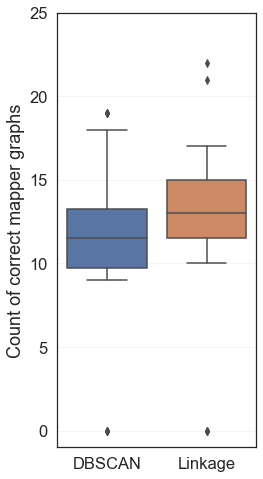

In [8]:
plt.figure(figsize=(4,7))

sns.boxplot(data=counts_df, x='method', y='count', order=['DBSCAN', 'Linkage'])
plt.xlabel('')
plt.ylabel('Count of correct mapper graphs')
plt.grid(axis='y', alpha=0.2)
plt.ylim([-1,25])
plt.tight_layout()
# plt.show()
save_path = os.path.join(datadir, 'clust_methods.png')
plt.savefig(save_path, dpi=300)

In [17]:
X_link = counts_df[counts_df['method'] == 'Linkage']['count'].to_numpy()
X_dbscan = counts_df[counts_df['method'] == 'DBSCAN']['count'].to_numpy()
# assert len(X_dbscan) == len(X_link)
stats.ttest_ind(X_link, X_dbscan)

Ttest_indResult(statistic=0.573276407553332, pvalue=0.5703438760405446)

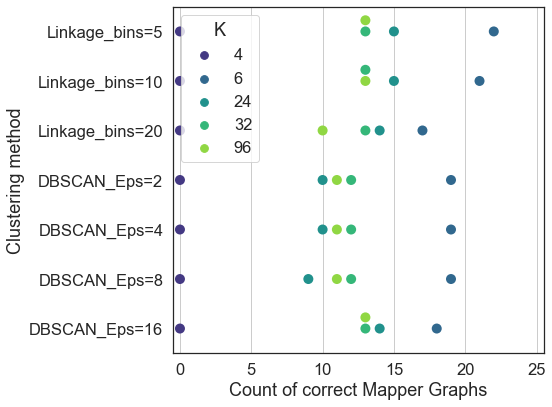

In [25]:
counts_df

clust_order = ['Linkage_bins=5',
 'Linkage_bins=10',
#  'Linkage_bins=15',
 'Linkage_bins=20',
 'DBSCAN_Eps=2',
 'DBSCAN_Eps=4',
 'DBSCAN_Eps=8',
 'DBSCAN_Eps=16']
counts_df['order'] = counts_df.apply(lambda row: clust_order.index(row['clust']), axis=1)

# WS1
cdf = counts_df.sort_values(by='order')
plt.figure(figsize=(8,6))
sns.swarmplot(data=cdf, x='count', y='clust', hue='K', size=10, palette='viridis') # , color='green'
plt.ylabel('Clustering method')
plt.xlabel('Count of correct Mapper Graphs')
plt.grid(axis='x')
plt.xlim([-0.5, 25.5])
# plt.title('Count of correct mapper graphs')
plt.tight_layout()
# plt.show()
save_path = os.path.join(datadir, 'perf_clusts.png')
plt.savefig(save_path, dpi=300)